In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
np.random.seed(0)
tf.random.set_random_seed(0)

2025-09-16 00:23:21.479021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:

class PhysicsInformedNN:
    it = 0
    
    def __init__(self, X_u, u, X_f, layers,lb, ub,vf,rho_j,dropout_rate=0.05):
        self.vf = vf
        self.rho_j = rho_j
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.v = u[:,0:1]
        self.rho = u[:,1:2]
        
        self.layers = layers
        self.dropout_rate = dropout_rate
        
        self.weights, self.biases = self.initialize_NN(layers)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])   
        
        self.keep_prob = tf.placeholder_with_default(0.95, shape=())
                
        self.v_pred, self.rho_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pde, self.f_fd, self.f_loss = self.net_f(self.x_f_tf, self.t_f_tf) 
        
        self.loss = 0.4 * tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + 0.6 * tf.reduce_mean(tf.square(self.rho_tf - self.rho_pred)) +\
                         0.5* tf.reduce_mean(tf.square(self.f_pde)) + 0.5 *  tf.reduce_mean(tf.square(self.f_fd)) 
                         
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(0.001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):  
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0, num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0         # scaling
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.nn.dropout(H, keep_prob=self.keep_prob)  #  dropout
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        v = u[:,0:1]
        rho = u[:,1:2]
        return v,rho
    
    def net_f(self, x,t):
        v,rho = self.net_u(x,t)
        rho_t = tf.gradients(rho, t)[0] 
        rho_x = tf.gradients(rho, x)[0]
        v_x = tf.gradients(v, x)[0]
        f_pde = rho_t + rho * v_x + v * rho_x       #LWR的loss
        f_fd = self.vf * tf.exp(-rho/self.rho_j)-v  #基本图loss
        fd = self.vf * tf.exp(-rho/self.rho_j)     
        f_pde_2 = v + vf- fd     
        f_pde_3 = fd - v
        f_pde_2_t = tf.gradients(f_pde_2, t)[0]    
        f_pde_2_x = tf.gradients(f_pde_2, x)[0] 
        f_loss = f_pde_2_t + v * f_pde_2_x - (f_pde_3)/30   #二阶ARZ
        return f_pde, f_fd, f_loss

    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self,nIter):     
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.v_tf: self.v,self.rho_tf: self.rho,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f, self.keep_prob: 1 - self.dropout_rate}   
        
        start_time = time.time()
        MSE_history=[]
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it %100 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e' % 
                      (it, loss_value))
                MSE_history.append(loss_value)
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
        return MSE_history
    
    def predict(self, X_star):      
            
        v_star = self.sess.run(self.v_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2],self.keep_prob: 1 - self.dropout_rate})  
        rho_star = self.sess.run(self.rho_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2],self.keep_prob: 1 - self.dropout_rate})  
                
        f_v_star = self.sess.run(self.f_pde, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
        f_rho_star = self.sess.run(self.f_fd, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
        
        return v_star, rho_star
    
    
    def predict_mc(self, X_star, n_samples=50):
       
        v_samples = []
        rho_samples = []
        
        print('n_samples',n_samples)

        for _ in range(n_samples):
            tf_dict = {
                self.x_u_tf: X_star[:, 0:1],
                self.t_u_tf: X_star[:, 1:2],
                self.keep_prob: 1 - self.dropout_rate  
            }
            v_pred = self.sess.run(self.v_pred, tf_dict)
            print('---------------------------',v_pred)
            rho_pred = self.sess.run(self.rho_pred, tf_dict)
            v_samples.append(v_pred)
            rho_samples.append(rho_pred)

        v_samples = np.stack(v_samples, axis=0)
        rho_samples = np.stack(rho_samples, axis=0)
        

        v_mean = np.mean(v_samples, axis=0)
        rho_mean = np.mean(rho_samples, axis=0)
        v_std = np.std(v_samples, axis=0)
        rho_std = np.std(rho_samples, axis=0)

        return v_mean, rho_mean, v_std, rho_std,v_samples,rho_samples


In [3]:
if __name__ == "__main__": 
    layers = [2, 64, 64, 64, 64, 64, 64, 64, 64, 64, 2] #######
    
    import pickle
    file = open('US101_Lane1to5_t1.5s30.pickle', 'rb')
    info = pickle.load(file)
    speed=info['vMat'].T
    density = info['rhoMat'].T
    flat_arrayv = speed.flatten()
    flat_arrayrho = density.flatten()
    
    t=info['t']
    x=info['s']
    X, T = np.meshgrid(x,t)
    df = pd.DataFrame({'speed': flat_arrayv, 'density': flat_arrayrho,'x':x * 1770})
    # ------------- alpha = 0.01 --------------
    # vf = 26.5932
    # rho_j = 0.3008
    # ---------------------------
    # ------------- alpha = 0.08 --------------
    # vf = 25.1762
    # rho_j = 0.2663
    # ---------------------------
     # ------------- alpha = 0.15 --------------
    # vf = 24.8948
    # rho_j = 0.2491
    # ---------------------------
     # ------------- alpha = 0.22 --------------
    # vf = 24.6698
    # rho_j = 0.2386
    # ---------------------------
    # ------------- alpha = 0.29 --------------
    # vf = 24.4427
    # rho_j = 0.2314
    # ---------------------------
    # ------------- alpha = 0.36 --------------
    # vf = 24.2222
    # rho_j = 0.2256
    # ---------------------------
    # ------------- alpha = 0.43 --------------
    # vf = 24.0017
    # rho_j = 0.2207
    # ---------------------------
    # ------------- alpha = 0.50 --------------
    vf = 23.7619
    rho_j = 0.2164
    # ---------------------------
    # # ------------- alpha = 0.57 --------------
    # vf = 23.4925
    # rho_j = 0.2125
    # # ---------------------------
    # ------------- alpha = 0.64 --------------
    # vf = 23.1839
    # rho_j = 0.2089
    # # ---------------------------
    # ------------- alpha = 0.71 --------------
    # vf = 22.8114
    # rho_j = 0.2053
    # # ---------------------------
    # ------------- alpha = 0.78 --------------
    # vf = 22.3361
    # rho_j = 0.2018
    # # ---------------------------
    # ------------- alpha = 0.85 --------------
    # vf = 21.7062
    # rho_j = 0.1977
    # # ---------------------------
    # ------------- alpha = 0.92 --------------
    # vf = 20.6696
    # rho_j = 0.1926
    # # ---------------------------
    # ------------- alpha = 0.99 --------------
    # vf = 15.7383
    # rho_j = 0.1892
    # # ---------------------------
    
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = df.loc[:,['speed','density']]
    
    u_star = np.array(u_star.iloc[:,:])              
    
    
    lb = X_star.min(0)
    ub = X_star.max(0)  
    

    m = 12
    if m == 12:
        loopidx = [0,1,2,4,6,8,10,12,14,16,18,20]
    else:
        gap = int(len(x)/(m-1))
        loopidx = [i*gap for i in range(m-1)]
        loopidx.append(len(x)-1)
    span = np.array(loopidx)
    X_u_train = np.hstack([np.meshgrid(np.array(x)[span],t)[0].reshape(-1,1), np.meshgrid(np.array(x)[span],t)[1].reshape(-1,1) ])
    u_train = df[df['x'].isin(df.loc[span,:]['x'])].loc[:,['speed','density']]
    u_train = np.array(u_train.iloc[:,:])
    idx2 = np.random.choice(X_star.shape[0], int(X_star.shape[0] * 0.6), replace=False)
    X_f_train = X_star[idx2,:]
    data_list = [[] for i in range(2)]
    X_u_train = X_u_train[:, :]
    u_train = u_train[:,:]

    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers,lb, ub,vf,rho_j,dropout_rate=0.05)
    start_time = time.time()                
    model.train(20000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))

    v_pred, rho_pred = model.predict(X_star)
    print(v_pred)
    print(flat_arrayv)


    v_mean, rho_mean, v_std, rho_std,v_samples,rho_samples = model.predict_mc(X_star, n_samples=50)
    print("速度预测均值:", v_mean.flatten()[:5])
    print("速度预测标准差:", v_std.flatten()[:5])


2025-09-16 00:23:22.598147: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2025-09-16 00:23:22.627850: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600000000 Hz
2025-09-16 00:23:22.633732: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5577a48b9920 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-09-16 00:23:22.633747: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-09-16 00:23:22.635213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-09-16 00:23:22.746540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-16 00:23:

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a0:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




2025-09-16 00:23:23.240605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-09-16 00:23:23.240628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2025-09-16 00:23:23.240633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2025-09-16 00:23:23.240881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-16 00:23:23.242305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-16 00:23:23.243595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
20

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a0:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1/T

2025-09-16 00:23:26.886679: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886710: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886715: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886719: I tensorflow/core/common_runtime/placer.cc:54] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886725: I tensorflow/core/common_runtime/placer.cc:54] Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886727: I tensorflow/core/common_runtime/placer.cc:54] Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:26.886730: I tensorflow/core/common_runtime/placer.cc:54] Variable_1: (Variabl

dropout_7/mul_1_grad/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/dropout_7/mul_1_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/dropout_7/mul_1_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/dropout_7/mul_1_grad/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/dropout_7/mul_1_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/dropout_7/mul_1_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients/truediv_1_grad/RealDiv_grad/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients/truediv_1_grad/RealDiv_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients/truediv_1_grad/RealDiv_grad/RealDiv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients/truediv_1_grad/RealDiv_grad/Sum: (Sum): /job:localhost/repl

n_runtime/placer.cc:54] gradients_6/gradients_2/dropout_9/mul_1_grad/Mul_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:27.076854: I tensorflow/core/common_runtime/placer.cc:54] gradients_6/gradients_2/dropout_9/mul_1_grad/Mul_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:27.076870: I tensorflow/core/common_runtime/placer.cc:54] gradients_6/gradients_1/MatMul_11_grad/MatMul_grad/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:27.076898: I tensorflow/core/common_runtime/placer.cc:54] gradients_6/gradients_1/MatMul_11_grad/MatMul_grad/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:27.076916: I tensorflow/core/common_runtime/placer.cc:54] gradients_6/gradients_1/MatMul_11_grad/MatMul_grad/tuple/group_deps: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-09-16 00:23:27.076927: I tensorflow/core/co

/mul_grad/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/tuple/group_deps: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/dropout_14/mul_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/AddN_15: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradients_6/Tanh_14_grad/TanhGrad: (TanhGrad): /job:local

2025-09-16 00:23:28.964994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


It: 0, Loss: 3.020e+02
It: 100, Loss: 2.063e+01
It: 200, Loss: 9.886e+00
It: 300, Loss: 6.509e+00
It: 400, Loss: 5.599e+00
It: 500, Loss: 5.248e+00
It: 600, Loss: 5.055e+00
It: 700, Loss: 4.951e+00
It: 800, Loss: 4.820e+00
It: 900, Loss: 4.762e+00
It: 1000, Loss: 4.713e+00
It: 1100, Loss: 4.645e+00
It: 1200, Loss: 4.613e+00
It: 1300, Loss: 4.581e+00
It: 1400, Loss: 4.553e+00
It: 1500, Loss: 4.494e+00
It: 1600, Loss: 4.486e+00
It: 1700, Loss: 4.446e+00
It: 1800, Loss: 4.405e+00
It: 1900, Loss: 4.389e+00
It: 2000, Loss: 4.332e+00
It: 2100, Loss: 4.227e+00
It: 2200, Loss: 4.116e+00
It: 2300, Loss: 4.057e+00
It: 2400, Loss: 4.026e+00
It: 2500, Loss: 4.009e+00
It: 2600, Loss: 3.972e+00
It: 2700, Loss: 3.940e+00
It: 2800, Loss: 3.936e+00
It: 2900, Loss: 3.926e+00
It: 3000, Loss: 3.903e+00
It: 3100, Loss: 3.900e+00
It: 3200, Loss: 3.875e+00
It: 3300, Loss: 3.870e+00
It: 3400, Loss: 3.831e+00
It: 3500, Loss: 3.816e+00
It: 3600, Loss: 3.827e+00
It: 3700, Loss: 3.817e+00
It: 3800, Loss: 3.796e+0

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.201007
  Number of iterations: 2
  Number of functions evaluations: 10


Training time: 541.7626
[[10.537857 ]
 [10.688797 ]
 [11.500793 ]
 ...
 [ 9.918293 ]
 [10.112707 ]
 [10.3274145]]
[10.517886   10.82187587 11.7201514  ...  6.66410876  5.76945211
  6.93174673]
n_samples 50
--------------------------- [[10.644072]
 [10.132711]
 [10.398261]
 ...
 [10.31789 ]
 [10.095905]
 [ 9.91963 ]]
--------------------------- [[10.342382]
 [10.684319]
 [11.001307]
 ...
 [10.199064]
 [ 9.798397]
 [10.121724]]
--------------------------- [[10.225465 ]
 [ 9.760099 ]
 [11.0677185]
 ...
 [10.563017 ]
 [10.258018 ]
 [ 9.985711 ]]
--------------------------- [[10.286799 ]
 [10.253498 ]
 [11.1039505]
 ...
 [ 9.323302 ]
 [ 9.902135 ]
 [10.763159 ]]
--------------------------- [[10.929308 ]
 [10.507263 ]
 [11.8115425]
 ...
 [ 9.900194 ]
 [ 9.705511 ]
 [ 9.59885  ]]
--------------------------- [[ 9.625319 ]
 [10.714739 ]
 [11.126165 ]
 ...
 [10.5137005]
 [ 9.601797 ]
 [10.326704 ]]
--------------------------- [[10.238065 ]
 [10.225884 ]
 [11.042786 ]
 ...
 [10.340427 ]
 [ 9.9458

In [4]:
v_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
rho_pred = griddata(X_star, rho_pred.flatten(), (X, T), method='cubic')
# path= r'/root/autodl-tmp/code_planA/PIDL_LWR_10loops'
# import os
# np.save(os.path.join(path,'dropout_'+str(0.05)+'v_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=v_pred)#######
# np.save(os.path.join(path,'dropout_'+str(0.05)+'rho_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=rho_pred)#######

# np.save(os.path.join(path,'dropout_'+str(0.05)+'meanv_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=v_mean)#######
# np.save(os.path.join(path,'dropout_'+str(0.05)+'meanrho_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=rho_mean)#######
# np.save(os.path.join(path,'dropout_'+str(0.05)+'stdv_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=v_std)#######
# np.save(os.path.join(path,'dropout_'+str(0.05)+'stdrho_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=rho_std)#######

# np.save(os.path.join(path,'sample50_dropout_'+str(0.05)+'v_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=v_samples)#######
# np.save(os.path.join(path,'sample50_dropout_'+str(0.05)+'rho_alpha'+ str(0.50) + '_lwr_loop'+str(m) + '.npy'),arr=rho_samples)#######

In [5]:
x = rho_samples.flatten()
y = v_samples.flatten()

In [6]:
num_bins = 100
bin_edges = np.linspace(0.03, 0.6, num_bins + 1)

# 计算每个小区间x的均值
bin_means_x = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

# 统计每个小区间内的散点数值和计算均值
bin_counts = np.histogram(x, bins=bin_edges)[0]
bin_means = [np.mean(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(num_bins)]

# 计算方差
bin_variances = [np.var(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(num_bins)]
 # ------------------------ 真实的 ------------------------
    
# 统计每个小区间内的散点数值和计算均值
true_bin_counts = np.histogram(flat_arrayrho, bins=bin_edges)[0]
true_bin_means = [np.mean(flat_arrayv[(flat_arrayrho >= bin_edges[i]) & (flat_arrayrho < bin_edges[i + 1])]) for i in range(num_bins)]

# 计算方差
true_bin_variances = [np.var(flat_arrayv[(flat_arrayrho >= bin_edges[i]) & (flat_arrayrho < bin_edges[i + 1])]) for i in range(num_bins)]

最优参数 vf_lsm: 30.0
最优参数 kc_lsm: 0.1670859219477278
最优参数 m: 4.0


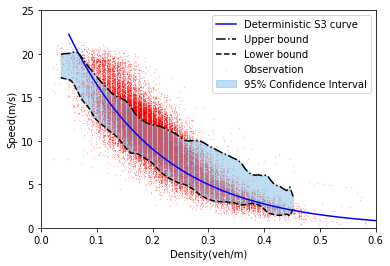

In [7]:
import numpy as np
from scipy.optimize import minimize

def func2(k, vm, kj):
    return vm*np.exp(-k/kj)

# 定义目标函数
def objective_lsm(params, x_data, y_data):
    vc,kj,m = params
    y_hat = func2(x_data, vc,kj)
    error = y_data - y_hat
    weighted_error = error
    cost = np.sum(weighted_error ** 2)
    return cost

# 初始参数猜测值
initial_guess = [30.0, 0.2,4]
# 使用优化算法找到最优参数
result_lsm = minimize(objective_lsm, initial_guess, args=(x, y))
vf_optimal_lsm, kc_optimal_lsm,m = result_lsm.x
print("最优参数 vf_lsm:", vf_optimal_lsm)
print("最优参数 kc_lsm:", kc_optimal_lsm)
print("最优参数 m:", m)

xx2 = np.arange(0.05, 0.6, 0.001)
x2 = bin_means_x
y2 = bin_means

yy2_mean = func2(xx2,vf_optimal_lsm,kc_optimal_lsm)

# 置信水平（这里使用95%置信水平）
confidence_level = 0.95 # 1.96; 85% -> 1.44
lower_bound_v_list = []
upper_bound_v_list = []
for i in range(100):
    # 计算标准差（方差的平方根）
    std_dev_v = np.sqrt(bin_variances[i])
    v_mean_arrayv = bin_means[i]
    # 计算置信区间的上下界
    margin_of_error_v = 1.96 * (std_dev_v)  # 对应95%置信水平的Z值
    lower_bound_v = v_mean_arrayv - margin_of_error_v
    upper_bound_v = v_mean_arrayv + margin_of_error_v
    lower_bound_v_list.append(lower_bound_v)
    upper_bound_v_list.append(upper_bound_v)
    
plt.scatter(flat_arrayrho,flat_arrayv,s=0.01,color='red',label='Observation')
plt.plot(xx2, yy2_mean,'b',label='Deterministic S3 curve')
# plt.scatter(x,y,s=0.01,color='blue',label='Observation')

# plt.scatter(x,y,s=0.01,color='grey',label='k-v')
# plt.scatter(x2, y2, marker='o',label='original values')
# plt.plot(bin_edges[1:], bin_means,'b',label='Mean')
plt.fill_between(bin_edges[1:], lower_bound_v_list, upper_bound_v_list, color='#7cbce6', alpha=0.5, zorder=2,label='95% Confidence Interval')
# 添加黑色虚线作为上下界
# 绘制虚线作为上下界
plt.plot(bin_edges[1:], upper_bound_v_list, 'k-.',label='Upper bound')
plt.plot(bin_edges[1:], lower_bound_v_list, 'k--',label='Lower bound')
plt.xlabel('Density(veh/m)')
plt.ylabel('Speed(m/s)')
plt.xlim(0, 0.6)
plt.ylim(0, 25)
plt.legend()
# plt.savefig("FD_CI_95.png", dpi=400, bbox_inches='tight')
plt.show()